## ICU Length of stay

In [2]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/
!ls
%pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
covid  icu_v4_merged_num_cat_top40.ipynb


'/content/gdrive/MyDrive/Colab Notebooks'

In [5]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv
#/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv

In [7]:
devices = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("covid/10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("covid/10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/covid/10k_synthea_covid19_csv/encounters.csv")


In [8]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [9]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [10]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [11]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [12]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [13]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [14]:
patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [15]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [16]:
# Careplan

careplan_df = pd.read_csv("covid/100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [17]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [18]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [19]:
#Conditions

conditions_df = pd.read_csv("covid/100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [20]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [21]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [22]:
medications_df = pd.read_csv("covid/100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [23]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [24]:
#Observations

observations_df = pd.read_csv("covid/100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [25]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [26]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [27]:
observations_df.head()

,patient,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Heart_rate,patient's_observation_of_Respiratory_rate,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Body_Weight,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_MCV_Entitic_volume_by_Automated_count,patient's_observation_of_Hemoglobin_Massvolume_in_Blood,...,patient's_observation_of_Bilirubintotal_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Monocytes100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Erythrocyte_distribution_width_Ratio_by_Automated_count,patient's_observation_of_Monocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Lymphocytes_volume_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
13517431,eff52d5c-7daa-49f5-bd1f-e5db679456fc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Hematocrit_Volume_Fraction_of_Blood_by_Automat...,2,2
16017856,9c6527df-8eed-4060-9273-bd61ebec4df0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,OxygenInspired_gas_setting_Volume_Fraction_Ven...,1,1
5404567,46861009-0dfe-44d3-9cab-ae5caba03c7d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Basophils100_leukocytes_in_Blood_by_Automated_...,1,1
12173167,6dcc13a0-325b-46cd-b095-7593de9bca42,0,0,0,0,60.5,0,0,0,0,...,0,0,0,0,0,0,0,Body_Weight,3,3
8717816,43c63e27-abbd-4772-ac2d-8bc8353a2b00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Platelets_volume_in_Blood_by_Automated_count,1,1


In [28]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [29]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [30]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [31]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [32]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [33]:
encounters = pd.read_csv("covid/100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("covid/10k_synthea_covid19_csv/encounters.csv")


In [34]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [35]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [36]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [37]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [38]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [39]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [40]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [41]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [42]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [43]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [44]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [45]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 752 unique patients.


In [46]:
data.fillna(0, inplace = True)

In [47]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [48]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [49]:
y = df['duration']
LABEL = "duration"

In [50]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [51]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [ ]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [52]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [53]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [54]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [55]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_MCV_Entitic_volume_by_Automated_count",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "patient's_observation_of_MCHC_Massvolume_by_Automated_count",
 "patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Glomer

In [56]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

## LightGBM

##### Let's start with initial LightGBM model. After seeing the feature importance plot, we will reduce features to top 40. Then we will see if it performs better with top40 features

In [80]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [81]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.0115131255709229

In [82]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.5352133330992401

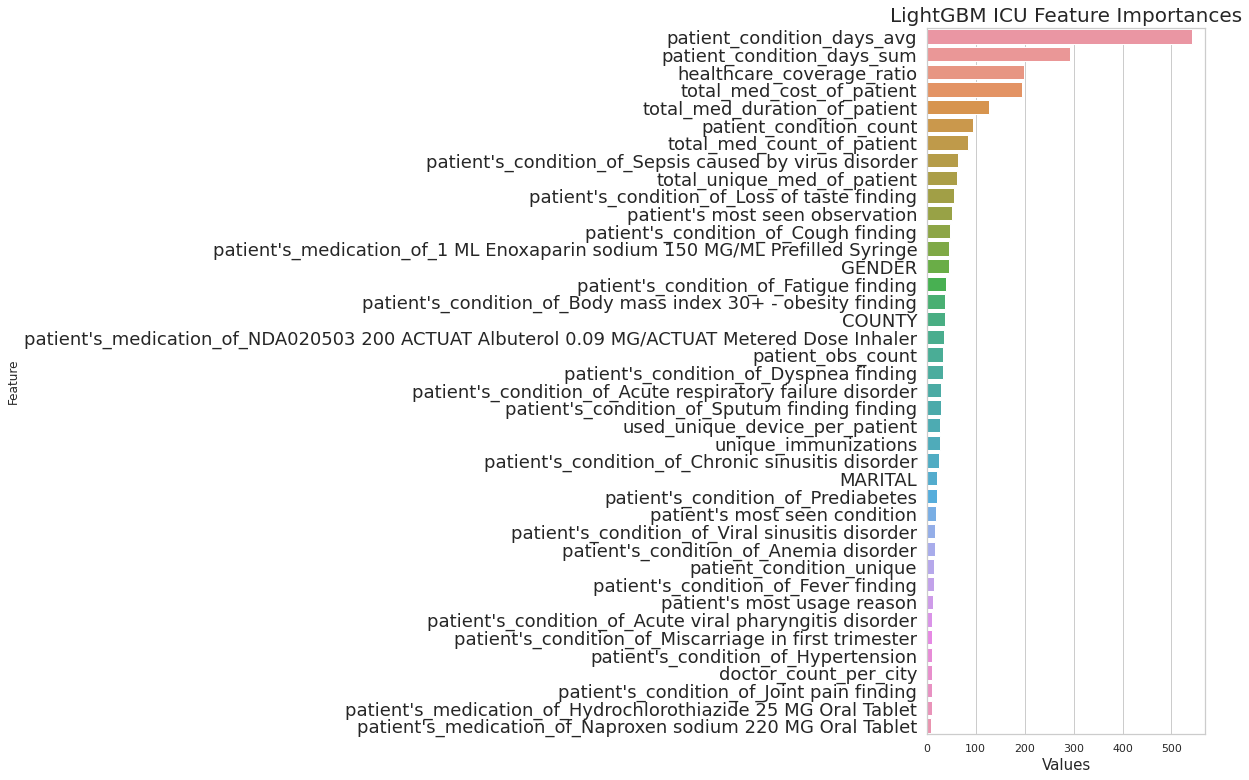

<Figure size 432x288 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:40])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [84]:
top40_features = feature_imp.sort_values("Value", ascending = False)[:40].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top40_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [132]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [133]:
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

0.9949238889378255

In [134]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.5204334897205434

#### It's indeed performing a bit better than initial model, by looking at both validation and test result we can say that

#### Let's tune some hyperparameters!

In [92]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = KFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}


{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}

In [135]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Validation Result {}".format(val_result2))
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)
print("Test Result {}".format(lgb_tuned_rmse))

Validation Result 0.9351149028876385
Test Result 1.422679242469647


In [136]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

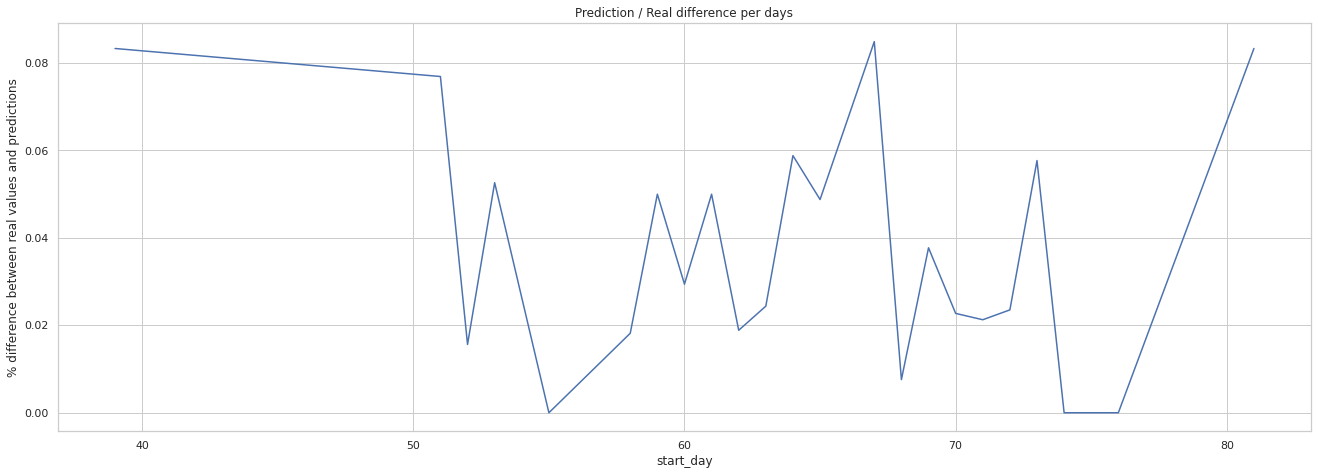

In [138]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

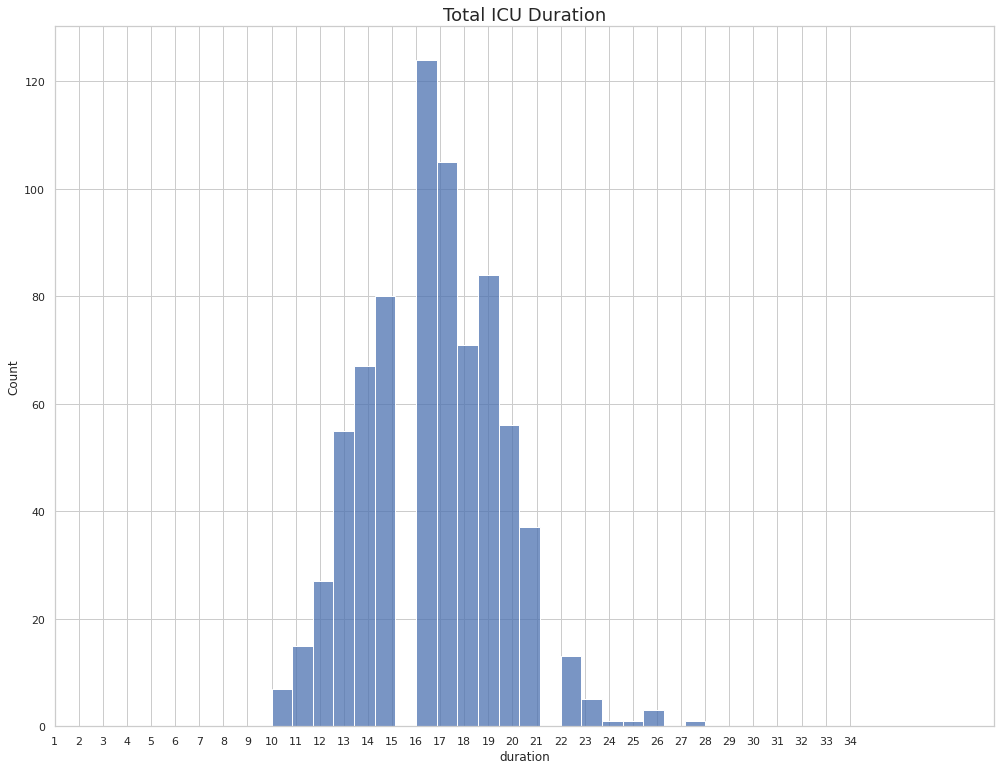

In [139]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

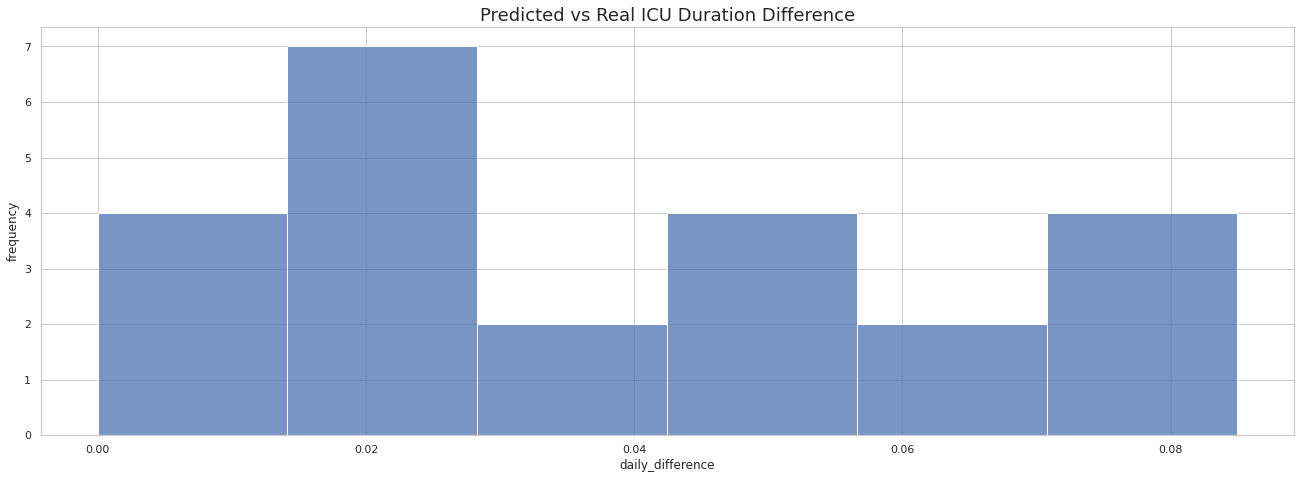

In [140]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

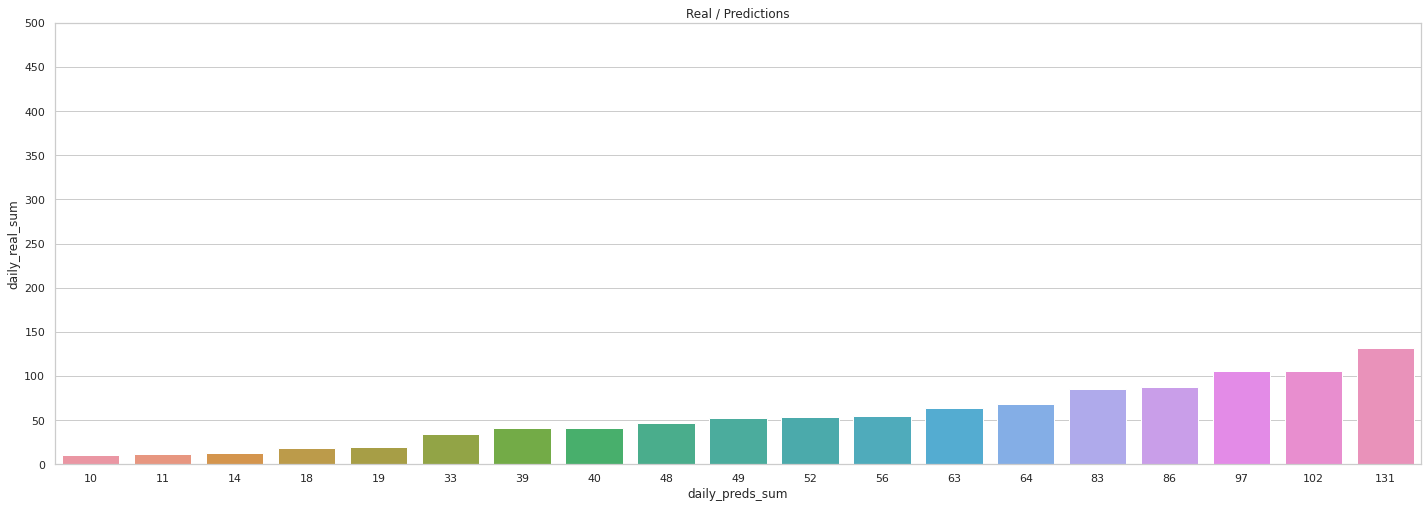

In [141]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

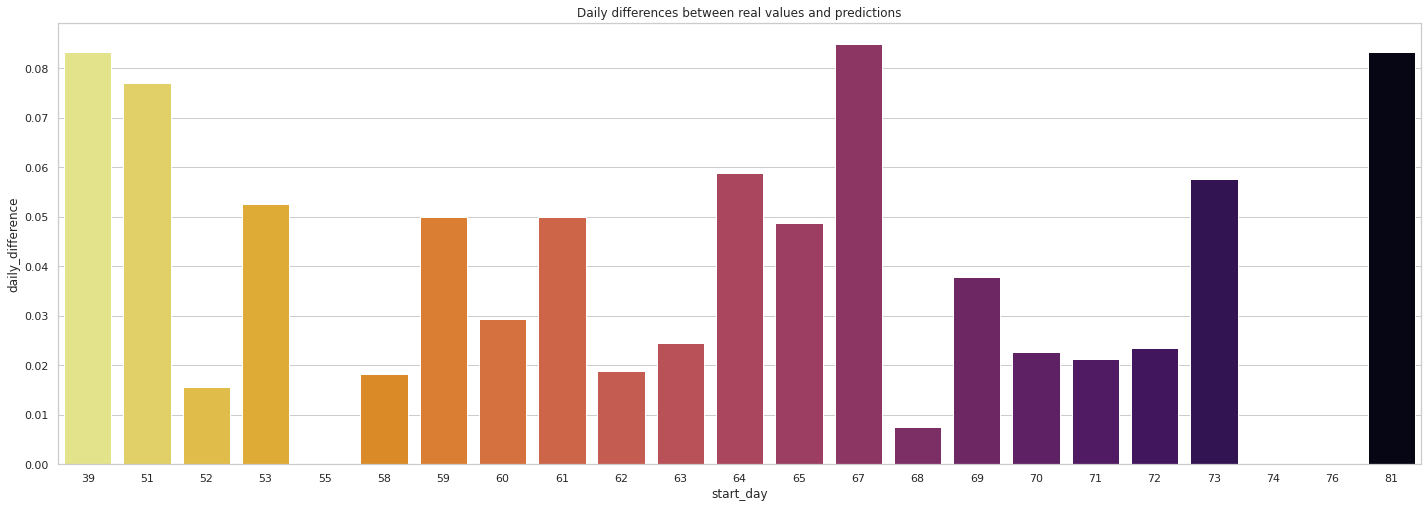

In [142]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [95]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.7 MB/s eta 0:00:00


In [96]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [98]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [99]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [100]:
y = data['duration']
LABEL = "duration"

In [101]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [102]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [104]:
CATEGORICAL_FEATURES

["patient's most seen observation",
 'GENDER',
 'COUNTY',
 'MARITAL',
 "patient's most seen condition",
 "patient's most usage reason"]

In [103]:
NUMERIC_FEATURES

['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'total_med_cost_of_patient',
 'total_med_duration_of_patient',
 'patient_condition_count',
 'total_med_count_of_patient',
 "patient's_condition_of_Sepsis caused by virus disorder",
 'total_unique_med_of_patient',
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Cough finding",
 "patient's_medication_of_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_medication_of_NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler",
 'patient_obs_count',
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Acute respiratory failure disorder",
 "patient's_condition_of_Sputum finding finding",
 'used_unique_device_per_patient',
 'unique_immunizations',
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Predia

In [105]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [106]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [107]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [108]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [110]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 7s 835ms/step - loss: 277.2727 - output_loss: 277.2727 - output_rmse: 16.6515 - val_loss: 226.1127 - val_output_loss: 226.1127 - val_output_rmse: 15.0370
Epoch 2/150
2/2 [==============================] - 0s 67ms/step - loss: 223.9168 - output_loss: 223.9168 - output_rmse: 14.9639 - val_loss: 192.8581 - val_output_loss: 192.8581 - val_output_rmse: 13.8873
Epoch 3/150
2/2 [==============================] - 0s 78ms/step - loss: 189.1885 - output_loss: 189.1885 - output_rmse: 13.7546 - val_loss: 171.0938 - val_output_loss: 171.0938 - val_output_rmse: 13.0803
Epoch 4/150
2/2 [==============================] - 0s 78ms/step - loss: 166.4444 - output_loss: 166.4444 - output_rmse: 12.9013 - val_loss: 151.6769 - val_output_loss: 151.6769 - val_output_rmse: 12.3157
Epoch 5/150
2/2 [==============================] - 0s 79ms/step - loss: 147.2191 - output_loss: 147.2191 - output_rmse: 12.1334 - val_loss: 136.4052 - val_output_loss: 136.4052 - val_

In [111]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 5s 674ms/step - loss: 279.9218 - output_loss: 279.9218 - output_rmse: 16.7309 - val_loss: 283.4156 - val_output_loss: 283.4156 - val_output_rmse: 16.8350
Epoch 2/150
2/2 [==============================] - 0s 54ms/step - loss: 267.9768 - output_loss: 267.9768 - output_rmse: 16.3700 - val_loss: 252.0695 - val_output_loss: 252.0695 - val_output_rmse: 15.8767
Epoch 3/150
2/2 [==============================] - 0s 52ms/step - loss: 247.9253 - output_loss: 247.9253 - output_rmse: 15.7456 - val_loss: 243.4585 - val_output_loss: 243.4585 - val_output_rmse: 15.6032
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 238.1203 - output_loss: 238.1203 - output_rmse: 15.4311 - val_loss: 236.0375 - val_output_loss: 236.0375 - val_output_rmse: 15.3635
Epoch 5/150
2/2 [==============================] - 0s 48ms/step - loss: 229.0107 - output_loss: 229.0107 - output_rmse: 15.1331 - val_loss: 228.9364 - val_output_loss: 228.9364 - val_

In [113]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 0s 13ms/step


In [114]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.9 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [115]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 00:08:54,552] A new study created in memory with name: no-name-4add0284-8a32-4623-a547-e312372d9e5b


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 265.7339 - output_loss: 265.7339 - output_rmse: 16.3013 - val_loss: 239.6521 - val_output_loss: 239.6521 - val_output_rmse: 15.4807
Epoch 2/150
2/2 [==============================] - 0s 83ms/step - loss: 227.4766 - output_loss: 227.4766 - output_rmse: 15.0823 - val_loss: 200.1887 - val_output_loss: 200.1887 - val_output_rmse: 14.1488
Epoch 3/150
2/2 [==============================] - 0s 82ms/step - loss: 195.5096 - output_loss: 195.5096 - output_rmse: 13.9825 - val_loss: 182.6464 - val_output_loss: 182.6464 - val_output_rmse: 13.5147
Epoch 4/150
2/2 [==============================] - 0s 74ms/step - loss: 175.7390 - output_loss: 175.7390 - output_rmse: 13.2567 - val_loss: 170.0134 - val_output_loss: 170.0134 - val_output_rmse: 13.0389
Epoch 5/150
2/2 [==============================] - 0s 92ms/step - loss: 162.5666 - output_loss: 162.5666 - output_rmse: 12.7502 - val_loss: 159.6437 - val_output_loss: 159.6437 - val_ou

[I 2023-01-26 00:09:20,520] Trial 0 finished with value: 3.254813418079851 and parameters: {'numerical_bins': 84, 'embedding_dim': 25, 'depth': 6, 'heads': 7, 'attn_dropout': 0.1246277285321078, 'ff_dropout': 0.19803736488753032}. Best is trial 0 with value: 3.254813418079851.


Epoch 1/150
2/2 [==============================] - 5s 675ms/step - loss: 268.8939 - output_loss: 268.8939 - output_rmse: 16.3980 - val_loss: 267.7886 - val_output_loss: 267.7886 - val_output_rmse: 16.3642
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 265.3274 - output_loss: 265.3274 - output_rmse: 16.2889 - val_loss: 263.9352 - val_output_loss: 263.9352 - val_output_rmse: 16.2461
Epoch 3/150
2/2 [==============================] - 0s 45ms/step - loss: 261.1205 - output_loss: 261.1205 - output_rmse: 16.1592 - val_loss: 261.4799 - val_output_loss: 261.4799 - val_output_rmse: 16.1703
Epoch 4/150
2/2 [==============================] - 0s 46ms/step - loss: 259.5657 - output_loss: 259.5657 - output_rmse: 16.1110 - val_loss: 259.3333 - val_output_loss: 259.3333 - val_output_rmse: 16.1038
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 256.3667 - output_loss: 256.3667 - output_rmse: 16.0115 - val_loss: 257.1948 - val_output_loss: 257.1948 - val_

[I 2023-01-26 00:09:41,121] Trial 1 finished with value: 3.2275137733958306 and parameters: {'numerical_bins': 134, 'embedding_dim': 9, 'depth': 3, 'heads': 2, 'attn_dropout': 0.357382406369115, 'ff_dropout': 0.45057925557631523}. Best is trial 1 with value: 3.2275137733958306.


Epoch 1/150
2/2 [==============================] - 5s 670ms/step - loss: 274.3886 - output_loss: 274.3886 - output_rmse: 16.5647 - val_loss: 151.5061 - val_output_loss: 151.5061 - val_output_rmse: 12.3088
Epoch 2/150
2/2 [==============================] - 0s 57ms/step - loss: 143.0014 - output_loss: 143.0014 - output_rmse: 11.9583 - val_loss: 112.9434 - val_output_loss: 112.9434 - val_output_rmse: 10.6275
Epoch 3/150
2/2 [==============================] - 0s 53ms/step - loss: 106.9352 - output_loss: 106.9352 - output_rmse: 10.3409 - val_loss: 90.3534 - val_output_loss: 90.3534 - val_output_rmse: 9.5054
Epoch 4/150
2/2 [==============================] - 0s 53ms/step - loss: 86.2205 - output_loss: 86.2205 - output_rmse: 9.2855 - val_loss: 75.0569 - val_output_loss: 75.0569 - val_output_rmse: 8.6635
Epoch 5/150
2/2 [==============================] - 0s 50ms/step - loss: 70.7208 - output_loss: 70.7208 - output_rmse: 8.4096 - val_loss: 63.1322 - val_output_loss: 63.1322 - val_output_rmse: 7

1/1 [==============================] - 1s 562ms/step


[I 2023-01-26 00:09:54,088] Trial 2 finished with value: 3.2637284807986617 and parameters: {'numerical_bins': 120, 'embedding_dim': 47, 'depth': 3, 'heads': 5, 'attn_dropout': 0.03689259118431343, 'ff_dropout': 0.060410148901989424}. Best is trial 1 with value: 3.2275137733958306.


Epoch 1/150
2/2 [==============================] - 5s 660ms/step - loss: 275.2905 - output_loss: 275.2905 - output_rmse: 16.5919 - val_loss: 274.8315 - val_output_loss: 274.8315 - val_output_rmse: 16.5780
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 261.5702 - output_loss: 261.5702 - output_rmse: 16.1731 - val_loss: 264.4912 - val_output_loss: 264.4912 - val_output_rmse: 16.2632
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 253.3695 - output_loss: 253.3695 - output_rmse: 15.9176 - val_loss: 258.0823 - val_output_loss: 258.0823 - val_output_rmse: 16.0649
Epoch 4/150
2/2 [==============================] - 0s 46ms/step - loss: 247.4840 - output_loss: 247.4840 - output_rmse: 15.7316 - val_loss: 252.9634 - val_output_loss: 252.9634 - val_output_rmse: 15.9048
Epoch 5/150
2/2 [==============================] - 0s 46ms/step - loss: 242.6554 - output_loss: 242.6554 - output_rmse: 15.5774 - val_loss: 248.3370 - val_output_loss: 248.3370 - val_

1/1 [==============================] - 1s 577ms/step


[I 2023-01-26 00:10:14,234] Trial 3 finished with value: 3.227166851034988 and parameters: {'numerical_bins': 150, 'embedding_dim': 12, 'depth': 3, 'heads': 2, 'attn_dropout': 0.08699974239967856, 'ff_dropout': 0.17694612293471446}. Best is trial 3 with value: 3.227166851034988.


Epoch 1/150
2/2 [==============================] - 4s 552ms/step - loss: 274.2422 - output_loss: 274.2422 - output_rmse: 16.5603 - val_loss: 237.7553 - val_output_loss: 237.7553 - val_output_rmse: 15.4193
Epoch 2/150
2/2 [==============================] - 0s 43ms/step - loss: 236.3941 - output_loss: 236.3941 - output_rmse: 15.3751 - val_loss: 213.7377 - val_output_loss: 213.7377 - val_output_rmse: 14.6198
Epoch 3/150
2/2 [==============================] - 0s 44ms/step - loss: 209.9832 - output_loss: 209.9832 - output_rmse: 14.4908 - val_loss: 195.3135 - val_output_loss: 195.3135 - val_output_rmse: 13.9755
Epoch 4/150
2/2 [==============================] - 0s 42ms/step - loss: 193.8229 - output_loss: 193.8229 - output_rmse: 13.9220 - val_loss: 180.4928 - val_output_loss: 180.4928 - val_output_rmse: 13.4348
Epoch 5/150
2/2 [==============================] - 0s 43ms/step - loss: 179.0580 - output_loss: 179.0580 - output_rmse: 13.3813 - val_loss: 164.7719 - val_output_loss: 164.7719 - val_

[I 2023-01-26 00:10:27,484] Trial 4 finished with value: 3.234374947444697 and parameters: {'numerical_bins': 46, 'embedding_dim': 44, 'depth': 2, 'heads': 2, 'attn_dropout': 0.34196390728244064, 'ff_dropout': 0.2897480943754903}. Best is trial 3 with value: 3.227166851034988.


Epoch 1/150
2/2 [==============================] - 7s 952ms/step - loss: 268.1154 - output_loss: 268.1154 - output_rmse: 16.3742 - val_loss: 250.7256 - val_output_loss: 250.7256 - val_output_rmse: 15.8343
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 253.4088 - output_loss: 253.4088 - output_rmse: 15.9188 - val_loss: 235.4233 - val_output_loss: 235.4233 - val_output_rmse: 15.3435
Epoch 3/150
2/2 [==============================] - 0s 69ms/step - loss: 241.4919 - output_loss: 241.4919 - output_rmse: 15.5400 - val_loss: 230.5853 - val_output_loss: 230.5853 - val_output_rmse: 15.1850
Epoch 4/150
2/2 [==============================] - 0s 72ms/step - loss: 230.5451 - output_loss: 230.5451 - output_rmse: 15.1837 - val_loss: 226.0018 - val_output_loss: 226.0018 - val_output_rmse: 15.0334
Epoch 5/150
2/2 [==============================] - 0s 60ms/step - loss: 223.2976 - output_loss: 223.2976 - output_rmse: 14.9431 - val_loss: 219.8667 - val_output_loss: 219.8667 - val_

[I 2023-01-26 00:10:55,432] Trial 5 finished with value: 3.2335306163422737 and parameters: {'numerical_bins': 51, 'embedding_dim': 12, 'depth': 5, 'heads': 7, 'attn_dropout': 0.4367533800932767, 'ff_dropout': 0.4023584133057979}. Best is trial 3 with value: 3.227166851034988.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 265.9139 - output_loss: 265.9139 - output_rmse: 16.3069 - val_loss: 164.9971 - val_output_loss: 164.9971 - val_output_rmse: 12.8451
Epoch 2/150
2/2 [==============================] - 0s 87ms/step - loss: 158.4328 - output_loss: 158.4328 - output_rmse: 12.5870 - val_loss: 112.2639 - val_output_loss: 112.2639 - val_output_rmse: 10.5955
Epoch 3/150
2/2 [==============================] - 0s 87ms/step - loss: 108.8318 - output_loss: 108.8318 - output_rmse: 10.4322 - val_loss: 76.6968 - val_output_loss: 76.6968 - val_output_rmse: 8.7577
Epoch 4/150
2/2 [==============================] - 0s 89ms/step - loss: 72.2982 - output_loss: 72.2982 - output_rmse: 8.5028 - val_loss: 58.6767 - val_output_loss: 58.6767 - val_output_rmse: 7.6601
Epoch 5/150
2/2 [==============================] - 0s 89ms/step - loss: 53.3304 - output_loss: 53.3304 - output_rmse: 7.3028 - val_loss: 49.7859 - val_output_loss: 49.7859 - val_output_rmse: 7.05

[I 2023-01-26 00:11:20,712] Trial 6 finished with value: 3.260244660215909 and parameters: {'numerical_bins': 46, 'embedding_dim': 65, 'depth': 6, 'heads': 8, 'attn_dropout': 0.03715508359657049, 'ff_dropout': 0.12181649406434886}. Best is trial 3 with value: 3.227166851034988.


Epoch 1/150
2/2 [==============================] - 3s 432ms/step - loss: 208.2125 - output_loss: 208.2125 - output_rmse: 14.4296 - val_loss: 171.9926 - val_output_loss: 171.9926 - val_output_rmse: 13.1146
Epoch 2/150
2/2 [==============================] - 0s 39ms/step - loss: 160.7769 - output_loss: 160.7769 - output_rmse: 12.6798 - val_loss: 152.7591 - val_output_loss: 152.7591 - val_output_rmse: 12.3596
Epoch 3/150
2/2 [==============================] - 0s 36ms/step - loss: 145.2417 - output_loss: 145.2417 - output_rmse: 12.0516 - val_loss: 141.4869 - val_output_loss: 141.4869 - val_output_rmse: 11.8948
Epoch 4/150
2/2 [==============================] - 0s 37ms/step - loss: 134.8815 - output_loss: 134.8815 - output_rmse: 11.6139 - val_loss: 130.8839 - val_output_loss: 130.8839 - val_output_rmse: 11.4405
Epoch 5/150
2/2 [==============================] - 0s 39ms/step - loss: 124.3503 - output_loss: 124.3503 - output_rmse: 11.1512 - val_loss: 122.6920 - val_output_loss: 122.6920 - val_

[I 2023-01-26 00:11:37,250] Trial 7 finished with value: 1.2722399541299605 and parameters: {'numerical_bins': 61, 'embedding_dim': 44, 'depth': 1, 'heads': 6, 'attn_dropout': 0.046373375199166234, 'ff_dropout': 0.0861128679134957}. Best is trial 7 with value: 1.2722399541299605.


Epoch 1/150
2/2 [==============================] - 7s 835ms/step - loss: 266.6128 - output_loss: 266.6128 - output_rmse: 16.3283 - val_loss: 126.7117 - val_output_loss: 126.7117 - val_output_rmse: 11.2566
Epoch 2/150
2/2 [==============================] - 0s 76ms/step - loss: 148.9416 - output_loss: 148.9416 - output_rmse: 12.2042 - val_loss: 90.6986 - val_output_loss: 90.6986 - val_output_rmse: 9.5236
Epoch 3/150
2/2 [==============================] - 0s 73ms/step - loss: 103.7225 - output_loss: 103.7225 - output_rmse: 10.1844 - val_loss: 69.8176 - val_output_loss: 69.8176 - val_output_rmse: 8.3557
Epoch 4/150
2/2 [==============================] - 0s 73ms/step - loss: 75.8779 - output_loss: 75.8779 - output_rmse: 8.7108 - val_loss: 57.8865 - val_output_loss: 57.8865 - val_output_rmse: 7.6083
Epoch 5/150
2/2 [==============================] - 0s 75ms/step - loss: 57.5973 - output_loss: 57.5973 - output_rmse: 7.5893 - val_loss: 48.9716 - val_output_loss: 48.9716 - val_output_rmse: 6.99

[I 2023-01-26 00:11:57,363] Trial 8 finished with value: 3.2620004246846275 and parameters: {'numerical_bins': 159, 'embedding_dim': 82, 'depth': 4, 'heads': 8, 'attn_dropout': 0.3655347848564153, 'ff_dropout': 0.4349508608663815}. Best is trial 7 with value: 1.2722399541299605.


Epoch 1/150
2/2 [==============================] - 4s 559ms/step - loss: 281.0139 - output_loss: 281.0139 - output_rmse: 16.7635 - val_loss: 300.3650 - val_output_loss: 300.3650 - val_output_rmse: 17.3310
Epoch 2/150
2/2 [==============================] - 0s 44ms/step - loss: 279.9394 - output_loss: 279.9394 - output_rmse: 16.7314 - val_loss: 299.0960 - val_output_loss: 299.0960 - val_output_rmse: 17.2944
Epoch 3/150
2/2 [==============================] - 0s 46ms/step - loss: 276.6886 - output_loss: 276.6886 - output_rmse: 16.6340 - val_loss: 277.2658 - val_output_loss: 277.2658 - val_output_rmse: 16.6513
Epoch 4/150
2/2 [==============================] - 0s 48ms/step - loss: 270.6979 - output_loss: 270.6979 - output_rmse: 16.4529 - val_loss: 263.1448 - val_output_loss: 263.1448 - val_output_rmse: 16.2217
Epoch 5/150
2/2 [==============================] - 0s 46ms/step - loss: 260.1698 - output_loss: 260.1698 - output_rmse: 16.1298 - val_loss: 257.7402 - val_output_loss: 257.7402 - val_

[I 2023-01-26 00:12:17,205] Trial 9 finished with value: 3.232769535801801 and parameters: {'numerical_bins': 146, 'embedding_dim': 24, 'depth': 2, 'heads': 6, 'attn_dropout': 0.10067697975098688, 'ff_dropout': 0.374813881862402}. Best is trial 7 with value: 1.2722399541299605.


Number of finished trials: 10
Best trial: {'numerical_bins': 61, 'embedding_dim': 44, 'depth': 1, 'heads': 6, 'attn_dropout': 0.046373375199166234, 'ff_dropout': 0.0861128679134957}


In [116]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=61,
    embedding_dim=44,
    depth=1,
    heads=6,
    attn_dropout= 0.0463,
    ff_dropout= 0.0861,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 3s 432ms/step - loss: 278.3311 - output_loss: 278.3311 - output_rmse: 16.6833 - val_loss: 219.3325 - val_output_loss: 219.3325 - val_output_rmse: 14.8099
Epoch 2/250
2/2 [==============================] - 0s 36ms/step - loss: 206.1665 - output_loss: 206.1665 - output_rmse: 14.3585 - val_loss: 171.4188 - val_output_loss: 171.4188 - val_output_rmse: 13.0927
Epoch 3/250
2/2 [==============================] - 0s 35ms/step - loss: 161.9277 - output_loss: 161.9277 - output_rmse: 12.7251 - val_loss: 152.1059 - val_output_loss: 152.1059 - val_output_rmse: 12.3331
Epoch 4/250
2/2 [==============================] - 0s 37ms/step - loss: 144.1930 - output_loss: 144.1930 - output_rmse: 12.0080 - val_loss: 137.3135 - val_output_loss: 137.3135 - val_output_rmse: 11.7181
Epoch 5/250
2/2 [==============================] - 0s 35ms/step - loss: 130.6412 - output_loss: 130.6412 - output_rmse: 11.4298 - val_loss: 124.0039 - val_output_loss: 124.0039 - val_

In [117]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 382ms/step


### Periodic Encoding FT Transformer Model Graphs

In [118]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

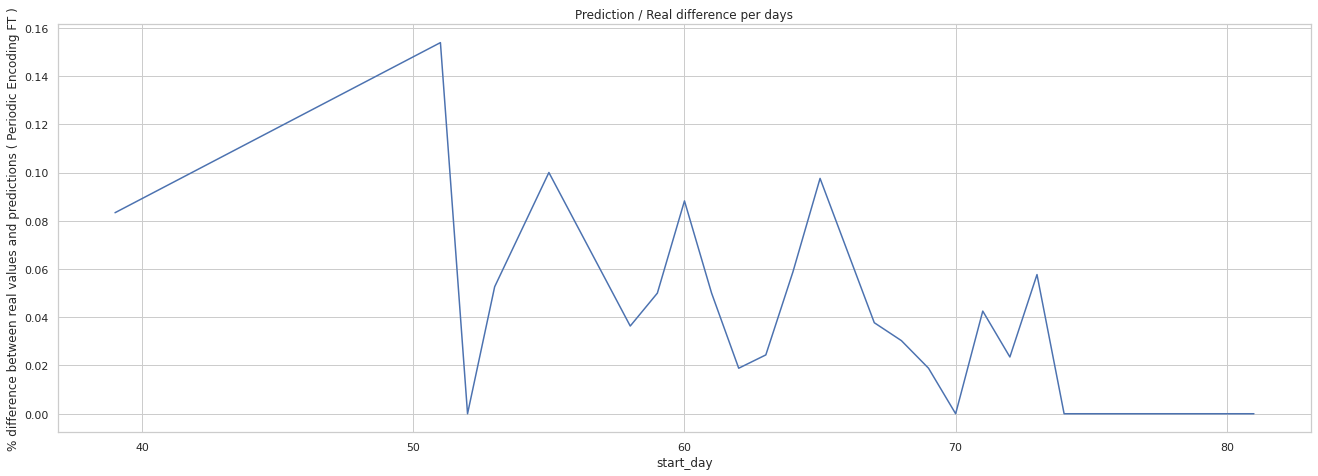

In [119]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

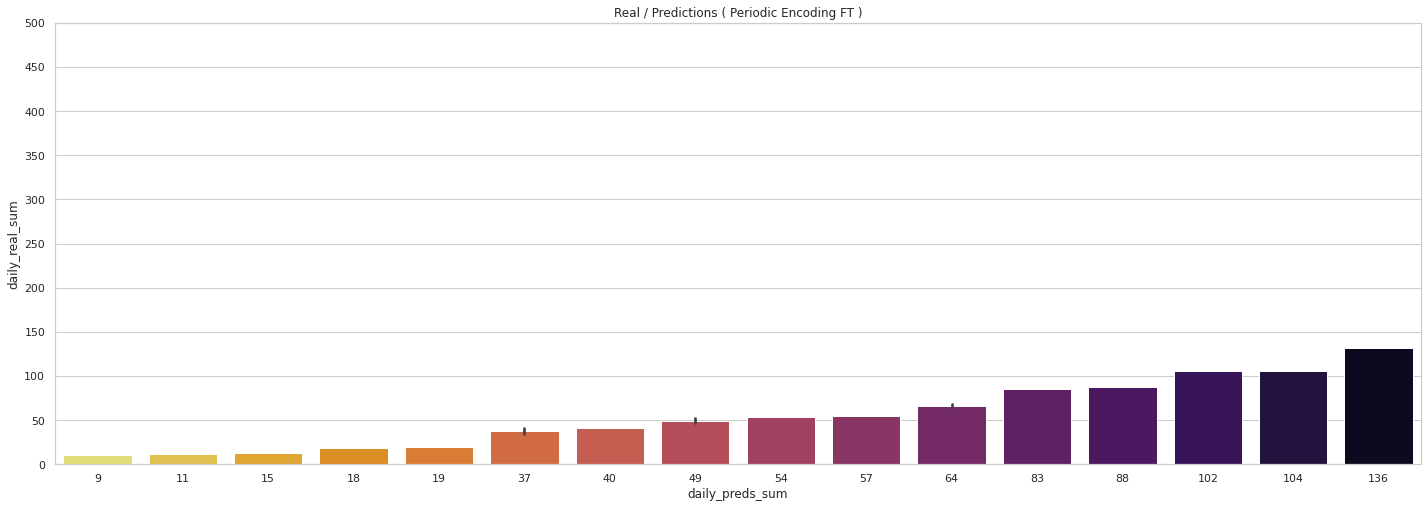

In [120]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

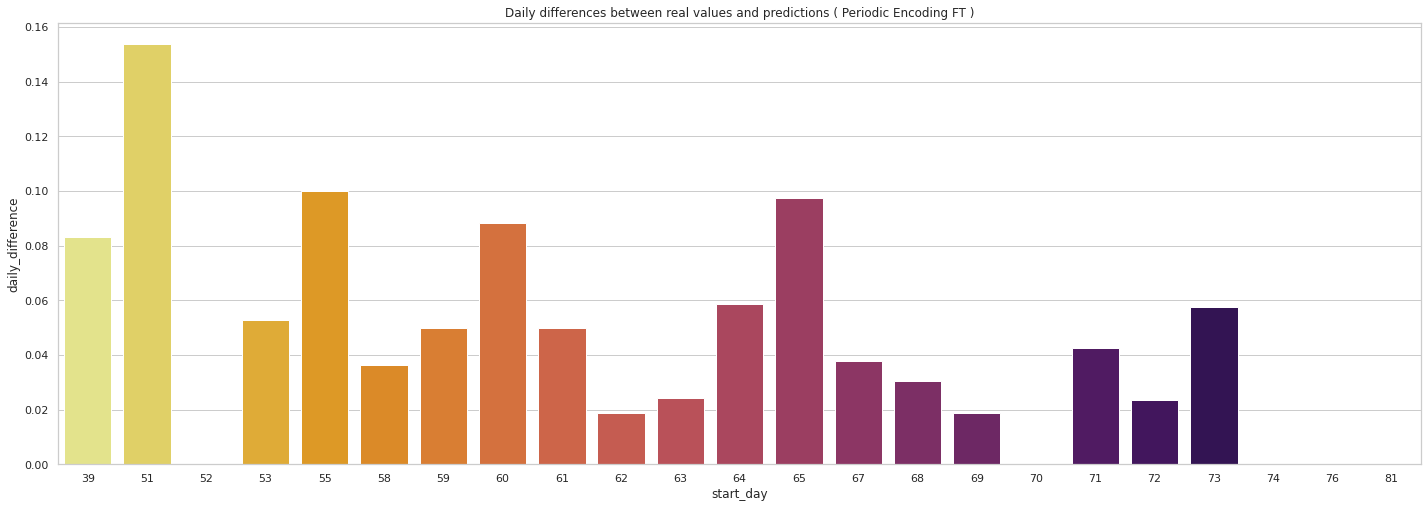

In [121]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [122]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 00:14:31,440] A new study created in memory with name: no-name-e6f96312-072d-42de-a899-8ec838455082


Epoch 1/150
2/2 [==============================] - 6s 784ms/step - loss: 279.3705 - output_loss: 279.3705 - output_rmse: 16.7144 - val_loss: 277.8379 - val_output_loss: 277.8379 - val_output_rmse: 16.6685
Epoch 2/150
2/2 [==============================] - 0s 54ms/step - loss: 264.7649 - output_loss: 264.7649 - output_rmse: 16.2716 - val_loss: 259.3252 - val_output_loss: 259.3252 - val_output_rmse: 16.1036
Epoch 3/150
2/2 [==============================] - 0s 54ms/step - loss: 249.0471 - output_loss: 249.0471 - output_rmse: 15.7812 - val_loss: 247.0727 - val_output_loss: 247.0727 - val_output_rmse: 15.7185
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 237.5497 - output_loss: 237.5497 - output_rmse: 15.4126 - val_loss: 237.4255 - val_output_loss: 237.4255 - val_output_rmse: 15.4086
Epoch 5/150
2/2 [==============================] - 0s 53ms/step - loss: 227.9742 - output_loss: 227.9742 - output_rmse: 15.0988 - val_loss: 230.2798 - val_output_loss: 230.2798 - val_

[I 2023-01-26 00:14:55,919] Trial 0 finished with value: 3.226565019624738 and parameters: {'numerical_bins': 32, 'embedding_dim': 12, 'depth': 4, 'heads': 7, 'attn_dropout': 0.12421037685032482, 'ff_dropout': 0.14553667488732436}. Best is trial 0 with value: 3.226565019624738.


Epoch 1/150
2/2 [==============================] - 3s 453ms/step - loss: 277.7473 - output_loss: 277.7473 - output_rmse: 16.6658 - val_loss: 233.9643 - val_output_loss: 233.9643 - val_output_rmse: 15.2959
Epoch 2/150
2/2 [==============================] - 0s 35ms/step - loss: 226.3996 - output_loss: 226.3996 - output_rmse: 15.0466 - val_loss: 207.5023 - val_output_loss: 207.5023 - val_output_rmse: 14.4049
Epoch 3/150
2/2 [==============================] - 0s 37ms/step - loss: 197.4186 - output_loss: 197.4186 - output_rmse: 14.0506 - val_loss: 188.7407 - val_output_loss: 188.7407 - val_output_rmse: 13.7383
Epoch 4/150
2/2 [==============================] - 0s 34ms/step - loss: 178.7827 - output_loss: 178.7827 - output_rmse: 13.3710 - val_loss: 171.2110 - val_output_loss: 171.2110 - val_output_rmse: 13.0848
Epoch 5/150
2/2 [==============================] - 0s 36ms/step - loss: 163.4345 - output_loss: 163.4345 - output_rmse: 12.7842 - val_loss: 155.4706 - val_output_loss: 155.4706 - val_

[I 2023-01-26 00:15:06,056] Trial 1 finished with value: 3.2549726044616385 and parameters: {'numerical_bins': 147, 'embedding_dim': 50, 'depth': 1, 'heads': 4, 'attn_dropout': 0.4887155079907519, 'ff_dropout': 0.0486675462632461}. Best is trial 0 with value: 3.226565019624738.


Epoch 1/150
2/2 [==============================] - 6s 775ms/step - loss: 280.8587 - output_loss: 280.8587 - output_rmse: 16.7588 - val_loss: 293.7133 - val_output_loss: 293.7133 - val_output_rmse: 17.1381
Epoch 2/150
2/2 [==============================] - 0s 58ms/step - loss: 275.6863 - output_loss: 275.6863 - output_rmse: 16.6038 - val_loss: 282.8416 - val_output_loss: 282.8416 - val_output_rmse: 16.8179
Epoch 3/150
2/2 [==============================] - 0s 58ms/step - loss: 265.6797 - output_loss: 265.6797 - output_rmse: 16.2997 - val_loss: 275.1756 - val_output_loss: 275.1756 - val_output_rmse: 16.5884
Epoch 4/150
2/2 [==============================] - 0s 53ms/step - loss: 257.5423 - output_loss: 257.5423 - output_rmse: 16.0481 - val_loss: 269.3393 - val_output_loss: 269.3393 - val_output_rmse: 16.4116
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 251.6754 - output_loss: 251.6754 - output_rmse: 15.8643 - val_loss: 265.0179 - val_output_loss: 265.0179 - val_

[I 2023-01-26 00:15:30,890] Trial 2 finished with value: 3.230722945539179 and parameters: {'numerical_bins': 66, 'embedding_dim': 12, 'depth': 4, 'heads': 8, 'attn_dropout': 0.22733816753036784, 'ff_dropout': 0.015206307110973039}. Best is trial 0 with value: 3.226565019624738.


Epoch 1/150
2/2 [==============================] - 5s 669ms/step - loss: 234.9689 - output_loss: 234.9689 - output_rmse: 15.3287 - val_loss: 89.8976 - val_output_loss: 89.8976 - val_output_rmse: 9.4814
Epoch 2/150
2/2 [==============================] - 0s 63ms/step - loss: 107.3863 - output_loss: 107.3863 - output_rmse: 10.3627 - val_loss: 52.5606 - val_output_loss: 52.5606 - val_output_rmse: 7.2499
Epoch 3/150
2/2 [==============================] - 0s 61ms/step - loss: 59.7590 - output_loss: 59.7590 - output_rmse: 7.7304 - val_loss: 37.0212 - val_output_loss: 37.0212 - val_output_rmse: 6.0845
Epoch 4/150
2/2 [==============================] - 0s 59ms/step - loss: 39.4146 - output_loss: 39.4146 - output_rmse: 6.2781 - val_loss: 26.5330 - val_output_loss: 26.5330 - val_output_rmse: 5.1510
Epoch 5/150
2/2 [==============================] - 0s 58ms/step - loss: 26.7477 - output_loss: 26.7477 - output_rmse: 5.1718 - val_loss: 19.3983 - val_output_loss: 19.3983 - val_output_rmse: 4.4044
Epo

[I 2023-01-26 00:15:42,345] Trial 3 finished with value: 3.2832449970178774 and parameters: {'numerical_bins': 157, 'embedding_dim': 91, 'depth': 3, 'heads': 6, 'attn_dropout': 0.26823270534189364, 'ff_dropout': 0.4328459605969391}. Best is trial 0 with value: 3.226565019624738.


Epoch 1/150
2/2 [==============================] - 4s 552ms/step - loss: 233.9574 - output_loss: 233.9574 - output_rmse: 15.2957 - val_loss: 56.8922 - val_output_loss: 56.8922 - val_output_rmse: 7.5427
Epoch 2/150
2/2 [==============================] - 0s 51ms/step - loss: 61.0399 - output_loss: 61.0399 - output_rmse: 7.8128 - val_loss: 18.6657 - val_output_loss: 18.6657 - val_output_rmse: 4.3204
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 22.1398 - output_loss: 22.1398 - output_rmse: 4.7053 - val_loss: 10.6619 - val_output_loss: 10.6619 - val_output_rmse: 3.2653
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 11.5040 - output_loss: 11.5040 - output_rmse: 3.3918 - val_loss: 8.3281 - val_output_loss: 8.3281 - val_output_rmse: 2.8858
Epoch 5/150
2/2 [==============================] - 0s 53ms/step - loss: 8.3111 - output_loss: 8.3111 - output_rmse: 2.8829 - val_loss: 7.7015 - val_output_loss: 7.7015 - val_output_rmse: 2.7752
Epoch 6/150


[I 2023-01-26 00:16:03,701] Trial 4 finished with value: 1.6027174853622914 and parameters: {'numerical_bins': 183, 'embedding_dim': 99, 'depth': 2, 'heads': 6, 'attn_dropout': 0.12860731208395682, 'ff_dropout': 0.231702739448496}. Best is trial 4 with value: 1.6027174853622914.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 245.3211 - output_loss: 245.3211 - output_rmse: 15.6627 - val_loss: 103.6568 - val_output_loss: 103.6568 - val_output_rmse: 10.1812
Epoch 2/150
2/2 [==============================] - 0s 79ms/step - loss: 115.0604 - output_loss: 115.0604 - output_rmse: 10.7266 - val_loss: 69.7775 - val_output_loss: 69.7775 - val_output_rmse: 8.3533
Epoch 3/150
2/2 [==============================] - 0s 75ms/step - loss: 71.6288 - output_loss: 71.6288 - output_rmse: 8.4634 - val_loss: 53.4292 - val_output_loss: 53.4292 - val_output_rmse: 7.3095
Epoch 4/150
2/2 [==============================] - 0s 74ms/step - loss: 52.2404 - output_loss: 52.2404 - output_rmse: 7.2277 - val_loss: 44.7440 - val_output_loss: 44.7440 - val_output_rmse: 6.6891
Epoch 5/150
2/2 [==============================] - 0s 81ms/step - loss: 42.0777 - output_loss: 42.0777 - output_rmse: 6.4867 - val_loss: 39.0317 - val_output_loss: 39.0317 - val_output_rmse: 6.2475
Epo

[I 2023-01-26 00:16:22,566] Trial 5 finished with value: 3.2885437689877373 and parameters: {'numerical_bins': 132, 'embedding_dim': 54, 'depth': 6, 'heads': 5, 'attn_dropout': 0.3499420281385874, 'ff_dropout': 0.24724469670446209}. Best is trial 4 with value: 1.6027174853622914.


Epoch 1/150
2/2 [==============================] - 7s 902ms/step - loss: 281.1542 - output_loss: 281.1542 - output_rmse: 16.7677 - val_loss: 285.7515 - val_output_loss: 285.7515 - val_output_rmse: 16.9042
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 273.7233 - output_loss: 273.7233 - output_rmse: 16.5446 - val_loss: 216.5258 - val_output_loss: 216.5258 - val_output_rmse: 14.7148
Epoch 3/150
2/2 [==============================] - 0s 67ms/step - loss: 221.1129 - output_loss: 221.1129 - output_rmse: 14.8699 - val_loss: 187.9502 - val_output_loss: 187.9502 - val_output_rmse: 13.7095
Epoch 4/150
2/2 [==============================] - 0s 66ms/step - loss: 185.2858 - output_loss: 185.2858 - output_rmse: 13.6120 - val_loss: 171.4712 - val_output_loss: 171.4712 - val_output_rmse: 13.0947
Epoch 5/150
2/2 [==============================] - 0s 67ms/step - loss: 165.9941 - output_loss: 165.9941 - output_rmse: 12.8839 - val_loss: 160.7755 - val_output_loss: 160.7755 - val_

[I 2023-01-26 00:16:48,855] Trial 6 finished with value: 3.2407466894463357 and parameters: {'numerical_bins': 198, 'embedding_dim': 53, 'depth': 5, 'heads': 5, 'attn_dropout': 0.30872524031392184, 'ff_dropout': 0.38036477926737106}. Best is trial 4 with value: 1.6027174853622914.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 276.1559 - output_loss: 276.1559 - output_rmse: 16.6179 - val_loss: 244.3063 - val_output_loss: 244.3063 - val_output_rmse: 15.6303
Epoch 2/150
2/2 [==============================] - 0s 74ms/step - loss: 257.7057 - output_loss: 257.7057 - output_rmse: 16.0532 - val_loss: 226.9259 - val_output_loss: 226.9259 - val_output_rmse: 15.0641
Epoch 3/150
2/2 [==============================] - 0s 74ms/step - loss: 235.8319 - output_loss: 235.8319 - output_rmse: 15.3568 - val_loss: 218.9304 - val_output_loss: 218.9304 - val_output_rmse: 14.7963
Epoch 4/150
2/2 [==============================] - 0s 72ms/step - loss: 218.6148 - output_loss: 218.6148 - output_rmse: 14.7856 - val_loss: 209.6834 - val_output_loss: 209.6834 - val_output_rmse: 14.4804
Epoch 5/150
2/2 [==============================] - 0s 72ms/step - loss: 205.3020 - output_loss: 205.3020 - output_rmse: 14.3284 - val_loss: 200.1160 - val_output_loss: 200.1160 - val_out

[I 2023-01-26 00:17:21,071] Trial 7 finished with value: 3.2317666187195244 and parameters: {'numerical_bins': 122, 'embedding_dim': 22, 'depth': 6, 'heads': 8, 'attn_dropout': 0.2302699169275233, 'ff_dropout': 0.444545066229692}. Best is trial 4 with value: 1.6027174853622914.


Epoch 1/150
2/2 [==============================] - 3s 428ms/step - loss: 267.0478 - output_loss: 267.0478 - output_rmse: 16.3416 - val_loss: 149.8621 - val_output_loss: 149.8621 - val_output_rmse: 12.2418
Epoch 2/150
2/2 [==============================] - 0s 41ms/step - loss: 146.9400 - output_loss: 146.9400 - output_rmse: 12.1219 - val_loss: 106.2392 - val_output_loss: 106.2392 - val_output_rmse: 10.3072
Epoch 3/150
2/2 [==============================] - 0s 41ms/step - loss: 109.1536 - output_loss: 109.1536 - output_rmse: 10.4477 - val_loss: 75.1899 - val_output_loss: 75.1899 - val_output_rmse: 8.6712
Epoch 4/150
2/2 [==============================] - 0s 40ms/step - loss: 81.6605 - output_loss: 81.6605 - output_rmse: 9.0366 - val_loss: 55.3263 - val_output_loss: 55.3263 - val_output_rmse: 7.4382
Epoch 5/150
2/2 [==============================] - 0s 40ms/step - loss: 61.8476 - output_loss: 61.8476 - output_rmse: 7.8643 - val_loss: 41.3053 - val_output_loss: 41.3053 - val_output_rmse: 6

[I 2023-01-26 00:17:37,676] Trial 8 finished with value: 1.5369885357925932 and parameters: {'numerical_bins': 162, 'embedding_dim': 82, 'depth': 1, 'heads': 6, 'attn_dropout': 0.09333376356693868, 'ff_dropout': 0.16546687378892339}. Best is trial 8 with value: 1.5369885357925932.


Epoch 1/150
2/2 [==============================] - 5s 682ms/step - loss: 277.3942 - output_loss: 277.3942 - output_rmse: 16.6552 - val_loss: 161.2074 - val_output_loss: 161.2074 - val_output_rmse: 12.6967
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 171.2548 - output_loss: 171.2548 - output_rmse: 13.0864 - val_loss: 87.9314 - val_output_loss: 87.9314 - val_output_rmse: 9.3772
Epoch 3/150
2/2 [==============================] - 0s 56ms/step - loss: 97.0603 - output_loss: 97.0603 - output_rmse: 9.8519 - val_loss: 61.4297 - val_output_loss: 61.4297 - val_output_rmse: 7.8377
Epoch 4/150
2/2 [==============================] - 0s 55ms/step - loss: 63.1824 - output_loss: 63.1824 - output_rmse: 7.9487 - val_loss: 52.0373 - val_output_loss: 52.0373 - val_output_rmse: 7.2137
Epoch 5/150
2/2 [==============================] - 0s 55ms/step - loss: 49.4377 - output_loss: 49.4377 - output_rmse: 7.0312 - val_loss: 46.7799 - val_output_loss: 46.7799 - val_output_rmse: 6.8396


[I 2023-01-26 00:17:51,363] Trial 9 finished with value: 3.2599831642431187 and parameters: {'numerical_bins': 70, 'embedding_dim': 88, 'depth': 3, 'heads': 5, 'attn_dropout': 0.3329386069391488, 'ff_dropout': 0.327189825185639}. Best is trial 8 with value: 1.5369885357925932.


Epoch 1/150
2/2 [==============================] - 3s 437ms/step - loss: 254.4590 - output_loss: 254.4590 - output_rmse: 15.9518 - val_loss: 168.5108 - val_output_loss: 168.5108 - val_output_rmse: 12.9812
Epoch 2/150
2/2 [==============================] - 0s 36ms/step - loss: 161.7631 - output_loss: 161.7631 - output_rmse: 12.7186 - val_loss: 123.2095 - val_output_loss: 123.2095 - val_output_rmse: 11.1000
Epoch 3/150
2/2 [==============================] - 0s 38ms/step - loss: 121.9244 - output_loss: 121.9244 - output_rmse: 11.0419 - val_loss: 99.7057 - val_output_loss: 99.7057 - val_output_rmse: 9.9853
Epoch 4/150
2/2 [==============================] - 0s 35ms/step - loss: 101.0357 - output_loss: 101.0357 - output_rmse: 10.0517 - val_loss: 83.1209 - val_output_loss: 83.1209 - val_output_rmse: 9.1171
Epoch 5/150
2/2 [==============================] - 0s 34ms/step - loss: 83.9963 - output_loss: 83.9963 - output_rmse: 9.1650 - val_loss: 71.4160 - val_output_loss: 71.4160 - val_output_rmse

[I 2023-01-26 00:17:59,668] Trial 10 finished with value: 3.3104426818394255 and parameters: {'numerical_bins': 92, 'embedding_dim': 75, 'depth': 1, 'heads': 2, 'attn_dropout': 0.0029238690086105246, 'ff_dropout': 0.13985486662714328}. Best is trial 8 with value: 1.5369885357925932.


Epoch 1/150
2/2 [==============================] - 4s 548ms/step - loss: 276.8070 - output_loss: 276.8070 - output_rmse: 16.6375 - val_loss: 162.5980 - val_output_loss: 162.5980 - val_output_rmse: 12.7514
Epoch 2/150
2/2 [==============================] - 0s 53ms/step - loss: 162.5460 - output_loss: 162.5460 - output_rmse: 12.7494 - val_loss: 92.5128 - val_output_loss: 92.5128 - val_output_rmse: 9.6184
Epoch 3/150
2/2 [==============================] - 0s 50ms/step - loss: 97.2609 - output_loss: 97.2609 - output_rmse: 9.8621 - val_loss: 64.2933 - val_output_loss: 64.2933 - val_output_rmse: 8.0183
Epoch 4/150
2/2 [==============================] - 0s 47ms/step - loss: 66.2725 - output_loss: 66.2725 - output_rmse: 8.1408 - val_loss: 50.8478 - val_output_loss: 50.8478 - val_output_rmse: 7.1308
Epoch 5/150
2/2 [==============================] - 0s 51ms/step - loss: 49.1198 - output_loss: 49.1198 - output_rmse: 7.0086 - val_loss: 42.7123 - val_output_loss: 42.7123 - val_output_rmse: 6.5355


[I 2023-01-26 00:18:10,997] Trial 11 finished with value: 3.3066531096442517 and parameters: {'numerical_bins': 196, 'embedding_dim': 100, 'depth': 2, 'heads': 6, 'attn_dropout': 0.1069010360472238, 'ff_dropout': 0.2380917279238458}. Best is trial 8 with value: 1.5369885357925932.


Epoch 1/150
2/2 [==============================] - 4s 552ms/step - loss: 228.9616 - output_loss: 228.9616 - output_rmse: 15.1315 - val_loss: 103.6904 - val_output_loss: 103.6904 - val_output_rmse: 10.1828
Epoch 2/150
2/2 [==============================] - 0s 47ms/step - loss: 107.6878 - output_loss: 107.6878 - output_rmse: 10.3773 - val_loss: 62.2555 - val_output_loss: 62.2555 - val_output_rmse: 7.8902
Epoch 3/150
2/2 [==============================] - 0s 46ms/step - loss: 66.9791 - output_loss: 66.9791 - output_rmse: 8.1841 - val_loss: 40.7796 - val_output_loss: 40.7796 - val_output_rmse: 6.3859
Epoch 4/150
2/2 [==============================] - 0s 43ms/step - loss: 44.3558 - output_loss: 44.3558 - output_rmse: 6.6600 - val_loss: 27.6246 - val_output_loss: 27.6246 - val_output_rmse: 5.2559
Epoch 5/150
2/2 [==============================] - 0s 43ms/step - loss: 29.8128 - output_loss: 29.8128 - output_rmse: 5.4601 - val_loss: 19.5477 - val_output_loss: 19.5477 - val_output_rmse: 4.4213


[I 2023-01-26 00:18:26,183] Trial 12 finished with value: 1.5059427750996206 and parameters: {'numerical_bins': 170, 'embedding_dim': 74, 'depth': 2, 'heads': 3, 'attn_dropout': 0.09083230003349657, 'ff_dropout': 0.18057309373848493}. Best is trial 12 with value: 1.5059427750996206.


Epoch 1/150
2/2 [==============================] - 4s 550ms/step - loss: 263.8142 - output_loss: 263.8142 - output_rmse: 16.2424 - val_loss: 141.4677 - val_output_loss: 141.4677 - val_output_rmse: 11.8940
Epoch 2/150
2/2 [==============================] - 0s 47ms/step - loss: 139.6274 - output_loss: 139.6274 - output_rmse: 11.8164 - val_loss: 98.4049 - val_output_loss: 98.4049 - val_output_rmse: 9.9199
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 98.6997 - output_loss: 98.6997 - output_rmse: 9.9348 - val_loss: 76.7227 - val_output_loss: 76.7227 - val_output_rmse: 8.7591
Epoch 4/150
2/2 [==============================] - 0s 44ms/step - loss: 76.2933 - output_loss: 76.2933 - output_rmse: 8.7346 - val_loss: 63.2076 - val_output_loss: 63.2076 - val_output_rmse: 7.9503
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 62.0924 - output_loss: 62.0924 - output_rmse: 7.8799 - val_loss: 53.0662 - val_output_loss: 53.0662 - val_output_rmse: 7.2847


[I 2023-01-26 00:18:36,229] Trial 13 finished with value: 3.3020316178580233 and parameters: {'numerical_bins': 170, 'embedding_dim': 74, 'depth': 2, 'heads': 3, 'attn_dropout': 8.394896775859584e-05, 'ff_dropout': 0.15017615588859987}. Best is trial 12 with value: 1.5059427750996206.


Epoch 1/150
2/2 [==============================] - 3s 424ms/step - loss: 255.1474 - output_loss: 255.1474 - output_rmse: 15.9733 - val_loss: 174.7367 - val_output_loss: 174.7367 - val_output_rmse: 13.2188
Epoch 2/150
2/2 [==============================] - 0s 39ms/step - loss: 179.1554 - output_loss: 179.1554 - output_rmse: 13.3849 - val_loss: 136.9644 - val_output_loss: 136.9644 - val_output_rmse: 11.7032
Epoch 3/150
2/2 [==============================] - 0s 34ms/step - loss: 150.3806 - output_loss: 150.3806 - output_rmse: 12.2630 - val_loss: 112.8229 - val_output_loss: 112.8229 - val_output_rmse: 10.6218
Epoch 4/150
2/2 [==============================] - 0s 36ms/step - loss: 131.0132 - output_loss: 131.0132 - output_rmse: 11.4461 - val_loss: 93.7380 - val_output_loss: 93.7380 - val_output_rmse: 9.6818
Epoch 5/150
2/2 [==============================] - 0s 35ms/step - loss: 111.0778 - output_loss: 111.0778 - output_rmse: 10.5393 - val_loss: 79.2459 - val_output_loss: 79.2459 - val_outpu

[I 2023-01-26 00:18:49,282] Trial 14 finished with value: 1.6208708472914344 and parameters: {'numerical_bins': 147, 'embedding_dim': 74, 'depth': 1, 'heads': 2, 'attn_dropout': 0.07494178659432801, 'ff_dropout': 0.32471498896582374}. Best is trial 12 with value: 1.5059427750996206.


Number of finished trials: 15
Best trial: {'numerical_bins': 170, 'embedding_dim': 74, 'depth': 2, 'heads': 3, 'attn_dropout': 0.09083230003349657, 'ff_dropout': 0.18057309373848493}


In [ ]:
study.best_trial.params

{'numerical_bins': 166,
 'embedding_dim': 39,
 'depth': 4,
 'heads': 6,
 'attn_dropout': 0.38521870058327434,
 'ff_dropout': 0.06051922059322673}

In [123]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=166,
    embedding_dim=39,
    depth=4,
    heads=6,
    attn_dropout= 0.3852,
    ff_dropout= 0.06051,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 6s 786ms/step - loss: 276.0876 - output_loss: 276.0876 - output_rmse: 16.6159 - val_loss: 212.0564 - val_output_loss: 212.0564 - val_output_rmse: 14.5622
Epoch 2/250
2/2 [==============================] - 0s 63ms/step - loss: 198.8828 - output_loss: 198.8828 - output_rmse: 14.1026 - val_loss: 173.0717 - val_output_loss: 173.0717 - val_output_rmse: 13.1557
Epoch 3/250
2/2 [==============================] - 0s 64ms/step - loss: 161.2222 - output_loss: 161.2222 - output_rmse: 12.6973 - val_loss: 144.6314 - val_output_loss: 144.6314 - val_output_rmse: 12.0263
Epoch 4/250
2/2 [==============================] - 0s 70ms/step - loss: 132.6170 - output_loss: 132.6170 - output_rmse: 11.5159 - val_loss: 116.8554 - val_output_loss: 116.8554 - val_output_rmse: 10.8100
Epoch 5/250
2/2 [==============================] - 0s 61ms/step - loss: 107.1427 - output_loss: 107.1427 - output_rmse: 10.3510 - val_loss: 100.8835 - val_output_loss: 100.8835 - val_

In [124]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 689ms/step


In [125]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 16ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

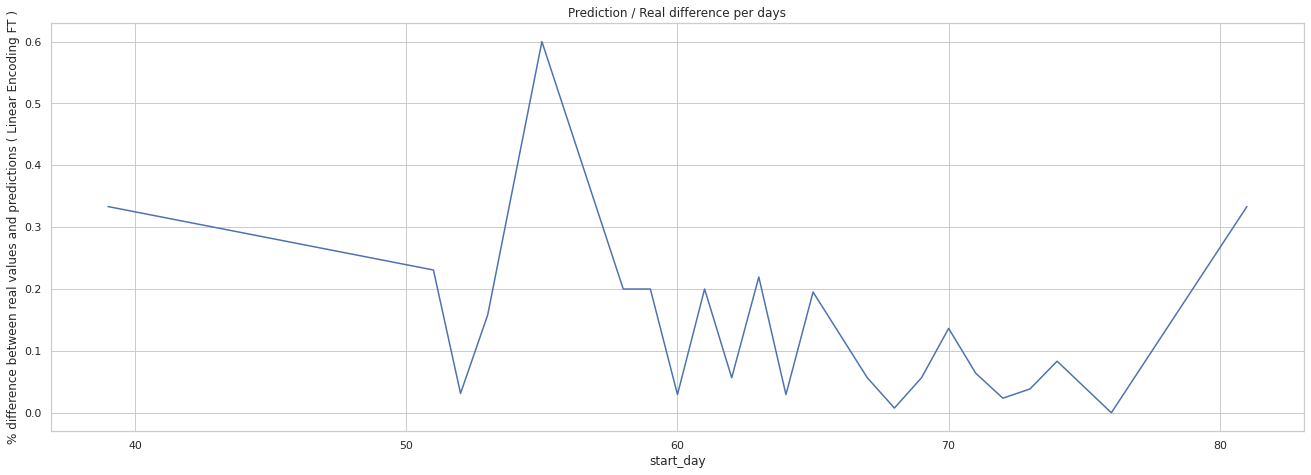

In [126]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

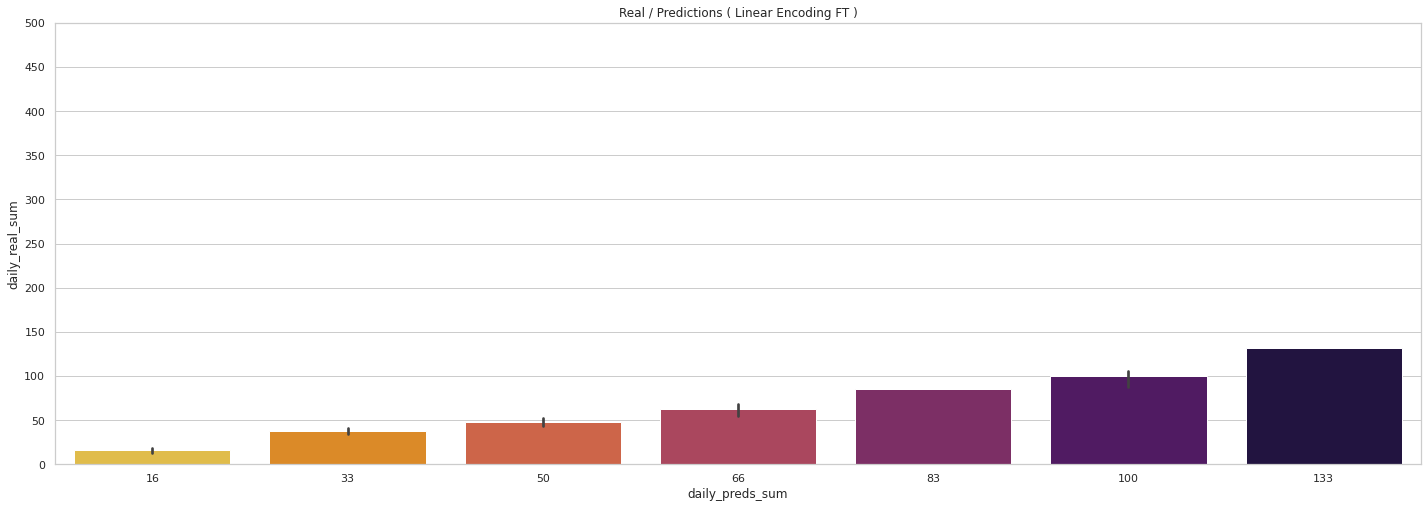

In [127]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

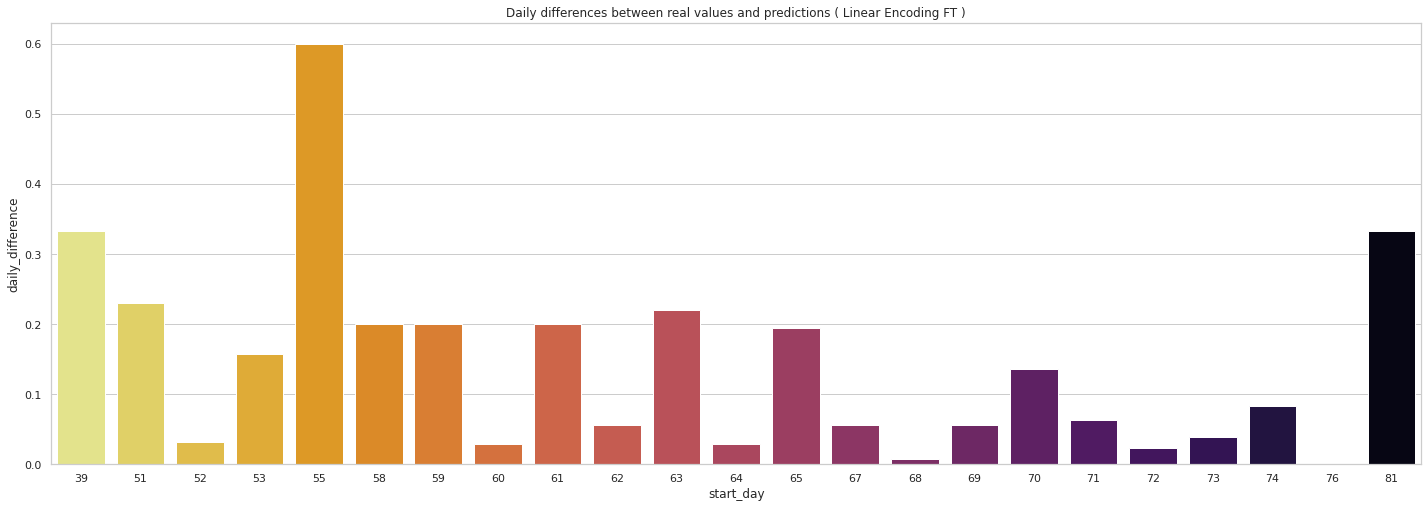

In [128]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [143]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.003259,2.645804,3.231511
Transformer - Periodic Encoding,-0.003259,2.644334,3.227652
LightGBM,0.777906,0.687538,1.520433


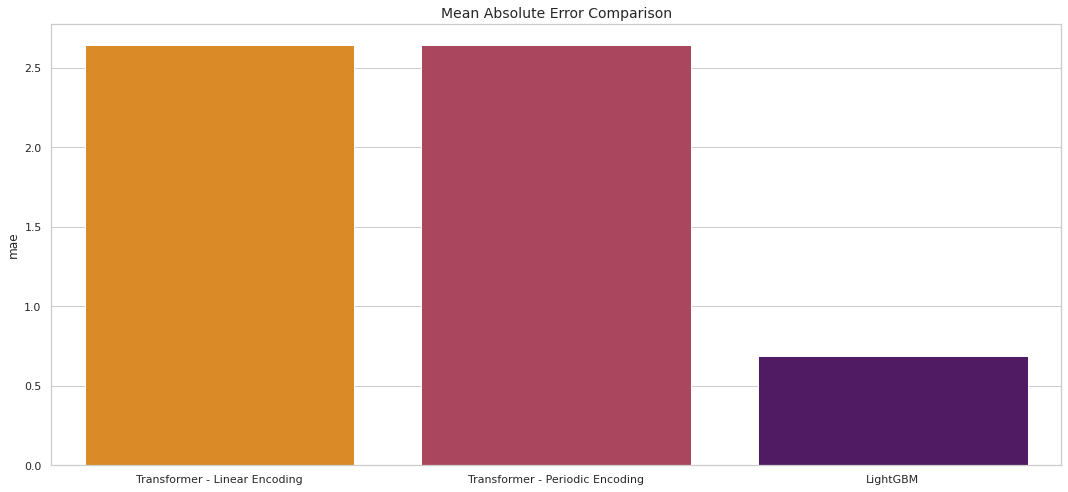

In [144]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


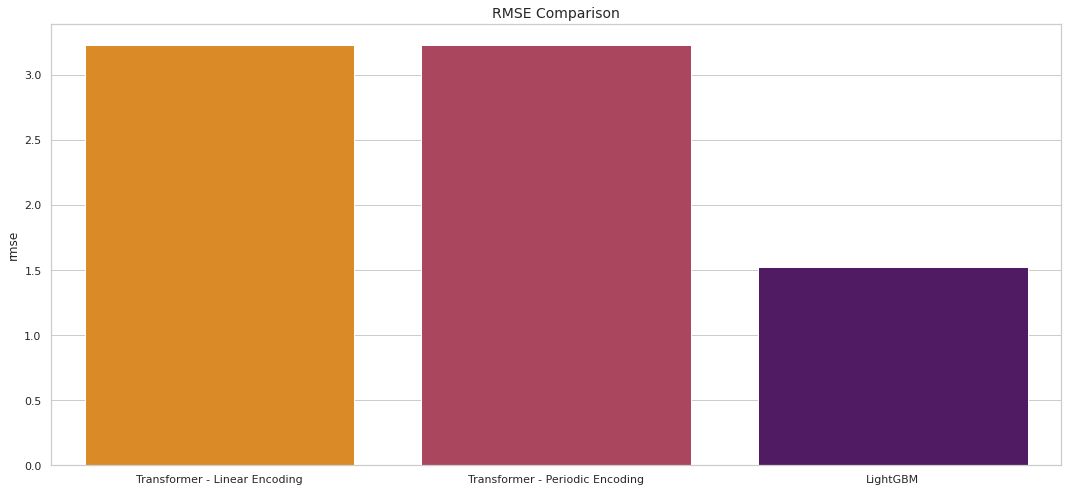

In [145]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


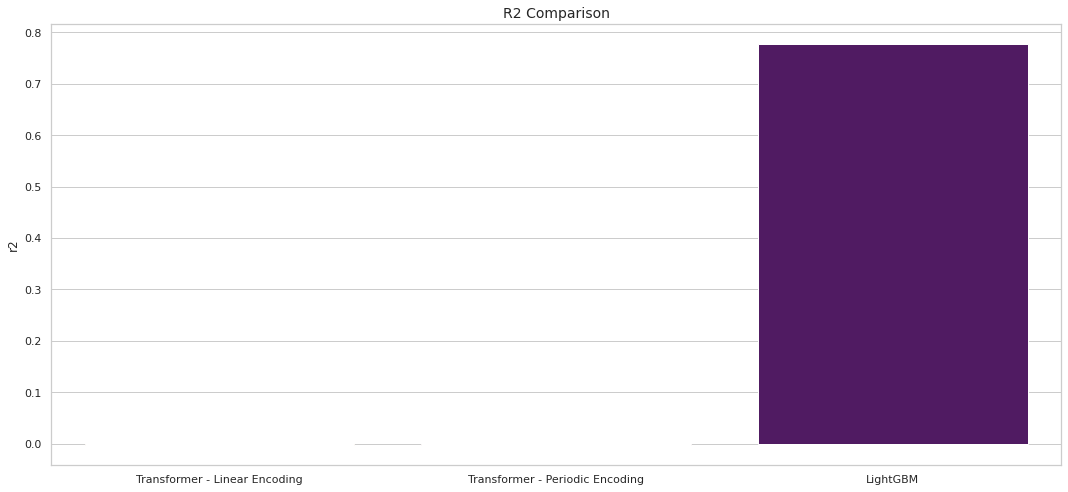

In [146]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [147]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.011147,2.648109,3.244190
Transformer - Periodic Encoding TUNED,0.800597,0.838966,1.440670
LightGBM TUNED,0.805546,0.688441,1.422679


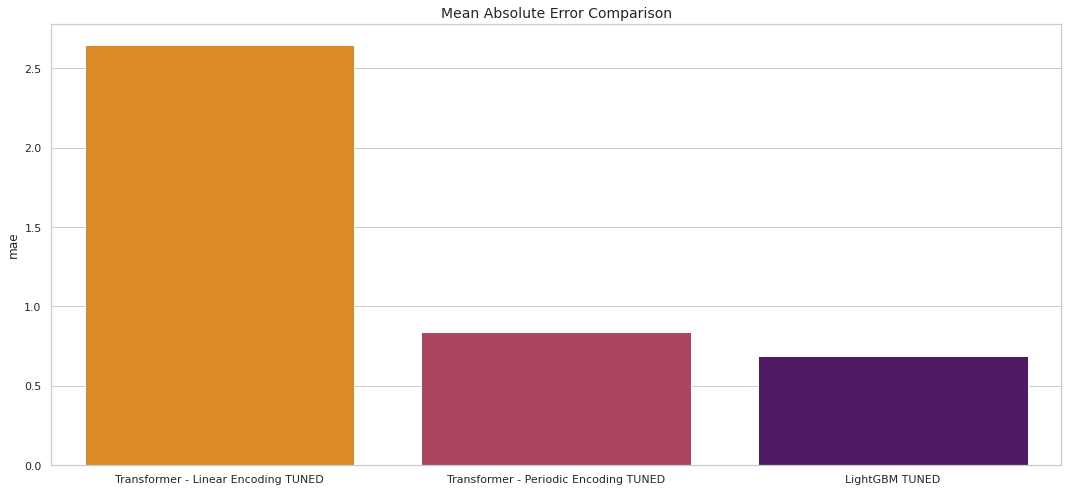

In [148]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


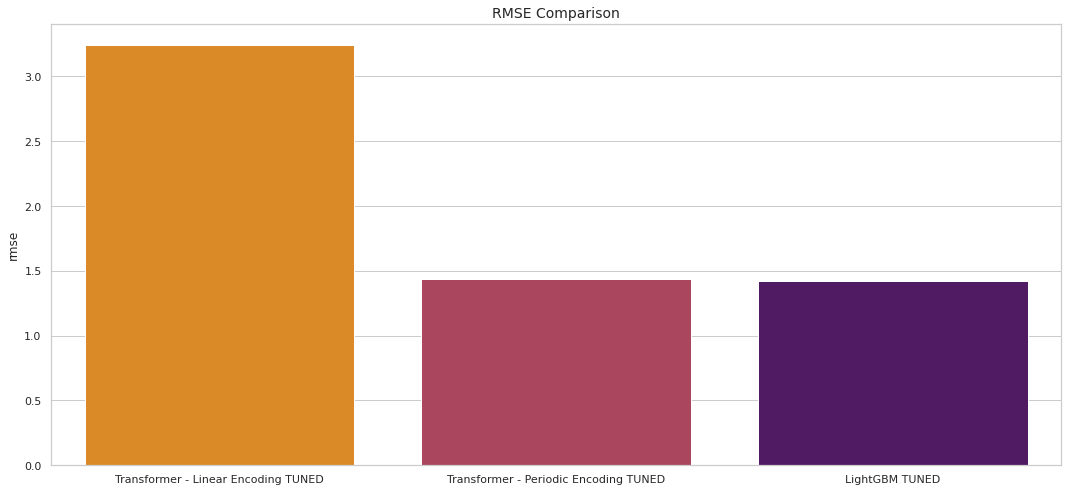

In [149]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


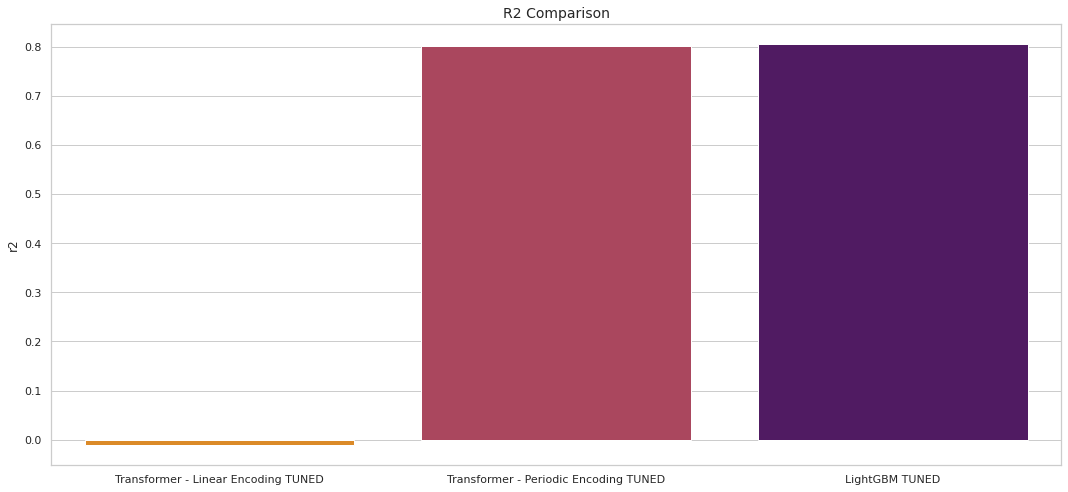

In [150]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
